# Get BTH, ETH price

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

start_date = "2021-08-26"
end_date = "2024-05-21"

btc_data = yf.download("BTC-USD", start=start_date, end=end_date)
eth_data = yf.download("ETH-USD", start=start_date, end=end_date)

btc_close = btc_data['Close']
eth_close = eth_data['Close']

btc_pct_change = btc_close.pct_change().fillna(0)
eth_pct_change = eth_close.pct_change().fillna(0)

btc_cum_growth = (1 + btc_pct_change).cumprod() - 1
eth_cum_growth = (1 + eth_pct_change).cumprod() - 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Load news label

In [27]:
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

def create_df(path:str, bull_var:int, bear_var:int, cum_number:float):

    with open(path, 'r', encoding='utf-8') as file:
        label_news = json.load(file)

    news_dates = []
    news_values = []

    for news in label_news:
        news_dates.append(news["date"])
        label = news["label"]
        if label == "bullish":
            news_values.append(bull_var)
        elif label == "bearish":
            news_values.append(bear_var)
        else:
            news_values.append(0)

    news_dates = pd.to_datetime(news_dates)
    news_df = pd.DataFrame({'Date': news_dates, 'Value': news_values})
    news_df = news_df.groupby('Date').sum().reset_index()
    news_df['Standardized_Value'] = scaler.fit_transform(news_df['Value'].values.reshape(-1, 1)) * 0.12
    news_df["Cum_art"] = news_df["Standardized_Value"].cumsum() * cum_number

    return news_df

cd_path = './news_data/news_with_label/cd_large.json'
amb_path = './news_data/news_with_label/amb.json'

cd_df = create_df(path=cd_path, bull_var=1, bear_var=-20, cum_number=0.08)
amb_df = create_df(path=amb_path, bull_var=1, bear_var=-1, cum_number=0.08)

# Plot

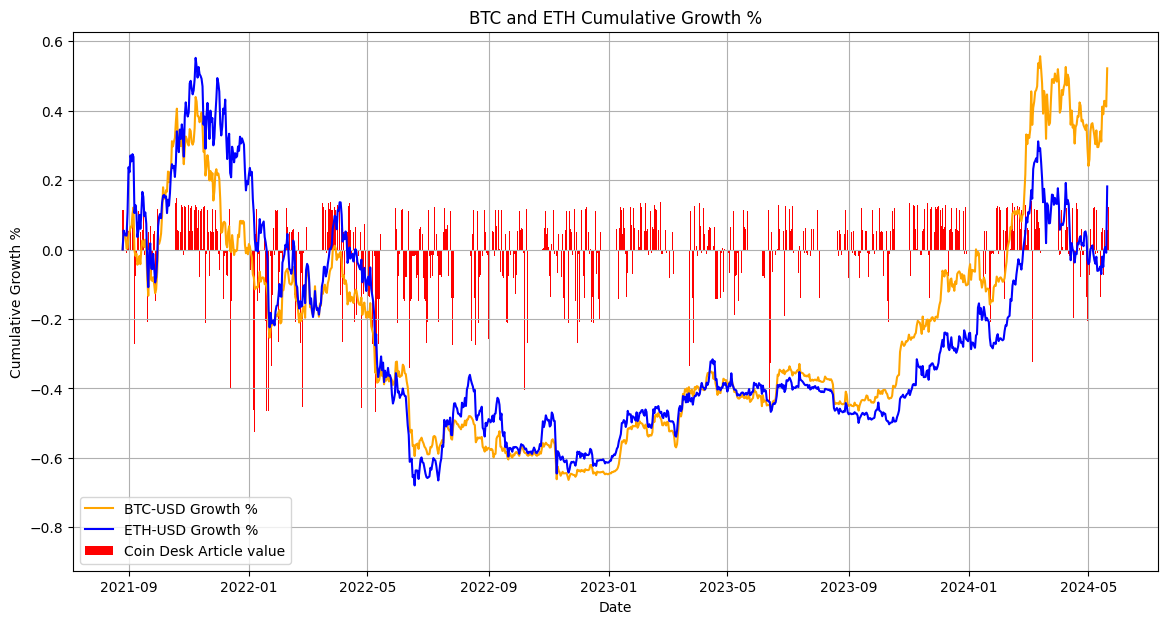

In [24]:
plt.figure(figsize=(14, 7))

plt.plot(btc_cum_growth, label='BTC-USD Growth %', color='orange')
plt.plot(eth_cum_growth, label='ETH-USD Growth %', color='blue')
plt.bar(cd_df['Date'], cd_df['Standardized_Value'], label='Coin Desk Article value', color='red')
#plt.bar(cs_df['Date'], cs_df['Standardized_Value'], label='Crypto Slate Article value', color='green')

plt.title('BTC and ETH Cumulative Growth %')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth %')
plt.legend()
plt.grid(True)
plt.show()

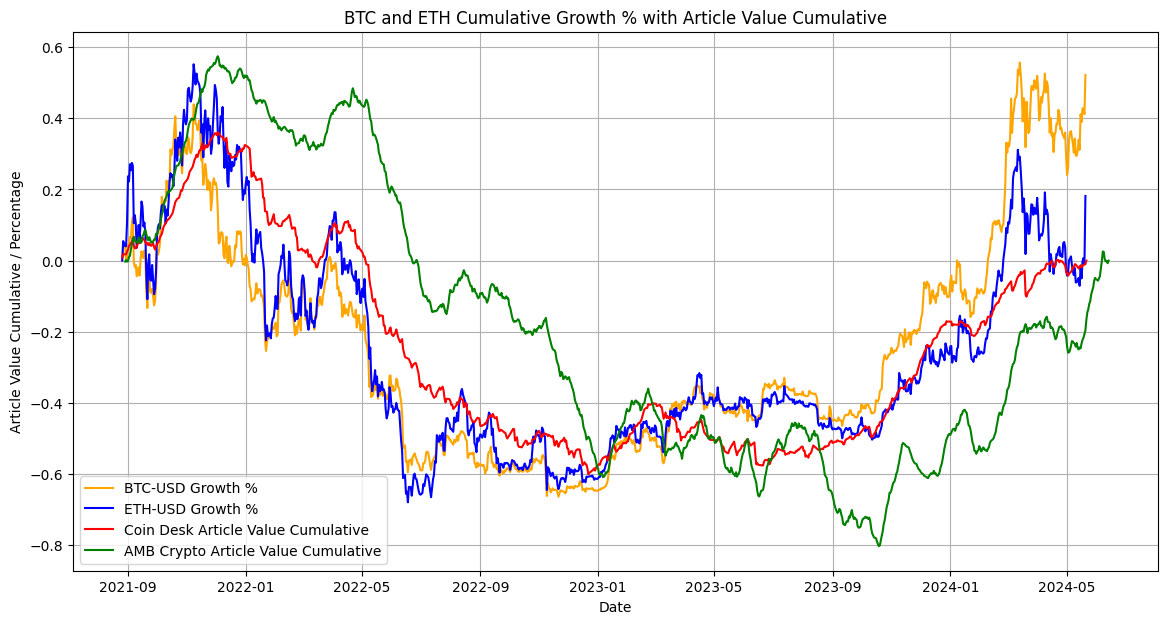

In [26]:
plt.figure(figsize=(14, 7))

plt.plot(btc_cum_growth, label='BTC-USD Growth %', color='orange')
plt.plot(eth_cum_growth, label='ETH-USD Growth %', color='blue')
plt.plot(cd_df['Date'], cd_df['Cum_art'], label='Coin Desk Article Value Cumulative', color='red')
plt.plot(amb_df['Date'], amb_df['Cum_art'], label='AMB Crypto Article Value Cumulative', color='green')

plt.title('BTC and ETH Cumulative Growth % with Article Value Cumulative')
plt.xlabel('Date')
plt.ylabel('Article Value Cumulative / Percentage')
plt.legend()
plt.grid(True)
plt.show()

# Find proper parm 

In [28]:
btc_df = pd.DataFrame(btc_cum_growth.reset_index())
btc_df.columns = ['Date', 'Value']
eth_df = pd.DataFrame(eth_cum_growth.reset_index())
eth_df.columns = ['Date', 'Value']

In [29]:
def correlation(df):
    correlation_btc = btc_df["Value"].corr(df['Cum_art'])
    correlation_eth = eth_df["Value"].corr(df['Cum_art'])
    print(f'BTC Correlation: {correlation_btc:.3f}')
    print(f'ETH Correlation: {correlation_eth:.3f}')

In [30]:
print('Coin Desk data:')
correlation(cd_df)

Coin Desk data:
BTC Correlation: 0.864
ETH Correlation: 0.836


In [31]:
print('AMB Crypto data:')
correlation(amb_df)

AMB Crypto data:
BTC Correlation: 0.405
ETH Correlation: 0.641
